# <오늘 할 것:>

# 1. YOLO


# 2.

# 3.

Semantic Segmentation

Classification + Localization

Object Detection

Instance Segmentation

# YOLO

R-CNN: Region proposal이라는 수백개의 이미지 후보를 생성하고 각각에 대해서 분류
- 계산량이 많다.


YOLO는 격자 그리드로 나누어 한 번에 클래스를 판단하고 이를 통합해 최종 객체를 구분
- scanning을 하지 않는다.
- 그리드 단위로 클래스를 판단한다; 이 그리드는 개인가 고양이인가 자전거인가
    - confidence: 각각의 클래스에 대한 확률
- 각 그리드를 센터로 가정했을 때 bounding box를 계산한다.
    - bounding box: 오브젝트의 존재 범위
    - v1, v2는 그리드 당 두 개씩; v3는 세 개씩 bounding box 후보를 내놓는다.
        - 엄청나게 많은 bounding box가 나온다.
            - grouping 해줘야 함. --> 평균?
                - confidence 기준으로 필터링
                - non-maximum suppression으로 합치기

    
<img src=featuremap.jpg>


YOLO3

1. 처음에는 13x13 그리드로 쪼갬
    - 13 * 13 * 3 * 85 = 507 * 85        
    
    #85 = 클래스 80개에 대한 확률 + (x, y, w, h, P)


2. 두번째는 26x26 그리드
    - 26 * 26 * 3 * 85 = 2028 * 85


3. 세번째는 52x52 그리드
    - 52 * 52 * 3 * 85 = 8112 * 85
 

# 1. 예제

In [1]:
import cv2 as cv
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold; 컨피던스가 이 값 미만이면 무시할 것임; 관행적으로 0.5를 쓴다.
nmsThreshold = 0.4   #Non-maximum suppression threshold; 주변보다 크거나 작은 값만 살림; 
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "coco.names"    #클래스명을 정리한 텍스트파일
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"     #네트워크를 구성하는 레이어들의 파라미터를 정리한 텍스트파일
modelWeights = "yolov3.weights"       #모델 학습 결과 도출된 weight값을 정리한 파일

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)    #`readNetFromDarknet`: 외부 config 정보와 weight 정보로 네트워크 구축
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)    #백엔드 지정
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## 네트워크 검토하기

1. `getLayerNames`
> 네트워크의 레이어명을 원소로 하는 리스트를 리턴한다.

    - `네트워크.getLayerNames()`


2. `getUnconnectedOutLayers`
> output 레이어의 인덱스를 2차원 배열로 리턴한다.

    - `네트워크.getUnconnectedOutLayers()`
    - 첫번째 레이어를 **1번** 레이어로 취급함
        - -1을 해주어서 인덱싱해야 원하는 레이어에 접근할 수 있다.

In [9]:
l = net.getLayerNames()
print(l)
print(len(l))    #254: 전체 레이어가 254개 아님; batch_normalization, activation 함수 적용 단계까지 하나의 레이어로 세기 때문

print(net.getUnconnectedOutLayers())

"""
[[200]
 [227]
 [254]]
[200-1    227-1     254-1]
"""
# [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

print(l[199])
print(l[226])
print(l[253])     #yolo 레이어만 출력됨

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [3]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [4]:
cap = cv.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

array([[[241, 230, 219],
        [241, 230, 219],
        [241, 230, 219],
        ...,
        [108, 142, 147],
        [102, 136, 141],
        [ 98, 132, 137]],

       [[241, 230, 219],
        [241, 230, 219],
        [241, 230, 219],
        ...,
        [ 96, 130, 135],
        [ 89, 123, 128],
        [ 85, 119, 124]],

       [[241, 230, 219],
        [241, 230, 219],
        [241, 230, 219],
        ...,
        [ 80, 108, 114],
        [ 73,  98, 105],
        [ 70,  95, 102]],

       ...,

       [[ 76,  88,  99],
        [ 76,  88,  99],
        [ 75,  89,  99],
        ...,
        [ 96,  92,  97],
        [ 96,  92,  97],
        [ 96,  92,  97]],

       [[ 78,  90, 101],
        [ 77,  89, 100],
        [ 76,  90, 100],
        ...,
        [ 95,  91,  96],
        [ 96,  92,  97],
        [ 96,  92,  97]],

       [[ 79,  91, 102],
        [ 78,  90, 101],
        [ 76,  90, 100],
        ...,
        [ 95,  91,  96],
        [ 95,  91,  96],
        [ 96,  92,  97]]

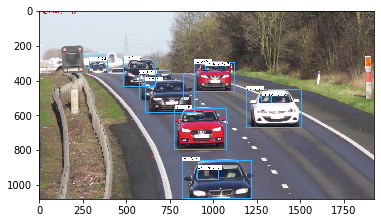

In [5]:
cv.imwrite("cars_out.jpg", frame) 
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(img)

<img src=cars_out.jpg>